In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from janome.tokenizer import Tokenizer
from typing import Union, Optional
from ptitprince import RainCloud
import japanize_matplotlib
from datetime import timedelta
from sklearn.metrics import mutual_info_score
import seaborn as sns

In [2]:
def insert_columns(
        df: pd.DataFrame,
        data: Union[pd.Series, pd.DataFrame],
        *,
        before: Optional[str] = None,
        after: Optional[str] = None,
        allow_duplicates: bool = False,
        inplace: bool = False,
    ) -> pd.DataFrame:

    if not inplace:
        df = df.copy()

    if not (after is None) ^ (before is None):
        raise ValueError('Specify only "before" or "after"')

    if before:
        loc = df.columns.get_loc(before)
    else:
        loc = df.columns.get_loc(after) + 1

    if type(data) is pd.Series:
        df.insert(loc, data.name, data, allow_duplicates)
    elif type(data) is pd.DataFrame:
        for column in data.columns[::-1]:
            df.insert(loc, column, data[column], allow_duplicates)

    return df

In [3]:
df_train = pd.read_csv('Deloitte_train.csv')
df_test = pd.read_csv('Deloitte_test.csv')
df_holidays = pd.read_csv('holidays_in_japan.csv')
df_venue = pd.read_csv('venue_information.csv')
df_match = pd.read_csv('match_reports.csv')

# 訓練データの統合及び整理

### df_venueをdf_train,df_testに統合

In [4]:
df_train.insert(8, 'capacity', 0)
df_train.insert(9, 'address', 0)

for i in range(len(df_train)):
    for q, j in enumerate(df_venue['venue']):
        if df_train['venue'][i] == j:
            df_train['capacity'][i] = df_venue['capacity'][q]
            df_train['address'][i] = df_venue['address'][q]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3785747752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['capacity'][i] = df_venue['capacity'][q]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3785747752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['address'][i] = df_venue['address'][q]


In [5]:
df_test.insert(8, 'capacity', 0)
df_test.insert(9, 'address', 0)

for i in range(len(df_test)):
    for q, j in enumerate(df_venue['venue']):
        if df_test['venue'][i] == j:
            df_test['capacity'][i] = df_venue['capacity'][q]
            df_test['address'][i] = df_venue['address'][q]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1554996274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['capacity'][i] = df_venue['capacity'][q]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1554996274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['address'][i] = df_venue['address'][q]


### df_matchから選手名のみ抽出

In [6]:
for n in range(len(df_match)):
    for i, j in enumerate(df_match.columns):
        if j != 'id':
            if j != 'home_team_score' and j != 'away_team_score':
                df_match[j][n] = df_match[j][n][:-3]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2011916765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match[j][n] = df_match[j][n][:-3]


In [7]:
for i, q in enumerate(df_match.columns):
    if q == 'id':
        pass
    elif q == 'home_team_score':
        pass
    elif q == 'away_team_score':
        pass
    else:
        for j in range(len(df_match)):
            df_match[q][j] = re.sub(r'[0-9]+', '', df_match[q][j])
            df_match[q][j] = df_match[q][j].replace(' ', '')

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2771777714.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match[q][j] = re.sub(r'[0-9]+', '', df_match[q][j])
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2771777714.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match[q][j] = df_match[q][j].replace(' ', '')


### df_matchをdf_train,df_testに統合

In [8]:
for i, j in enumerate(df_match.columns):
    if j != 'id':
        m = 5 + i
        df_train.insert(m, j, 0)
        for q in range(len(df_train)):
            df_train[j][q] = df_match[j][q]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\653823582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[j][q] = df_match[j][q]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\653823582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[j][q] = df_match[j][q]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\653823582.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[j][q] = df_match[j][q]
C:\User

In [9]:
for i, j in enumerate(df_match.columns):
    if j != 'id':
        m = 5 + i
        df_test.insert(m, j, 0)
        for q in range(len(df_test)):
            n = q + 3366
            df_test[j][q] = df_match[j][n]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2582913840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[j][q] = df_match[j][n]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2582913840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[j][q] = df_match[j][n]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2582913840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[j][q] = df_match[j][n]
C:\User

### 年、月、日、曜日、祝日を取得

In [10]:
df_train.insert(2, 'year', 0)
df_train.insert(3, 'month', 0)
df_train.insert(4, 'day', 0)
df_train.insert(5, 'day_of_week', 0)

def get_day_of_week_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

for i in range(len(df_train)):
    dt = datetime.datetime(int(df_train['match_date'][i][0:4]), int(df_train['match_date'][i][5:7]), int(df_train['match_date'][i][8:10]))
    df_train['year'][i] = str(dt.year) + '年'
    df_train['month'][i] = str(dt.month) + '月'
    df_train['day'][i] = str(dt.day) + '日'
    df_train['day_of_week'][i] = get_day_of_week_jp(dt)

for i in range(len(df_train)):
    for j in range(len(df_holidays)):
        if df_train['match_date'][i] in df_holidays['holiday_date'][j]:
            if df_train['day_of_week'][i] == '土曜日':
                pass
            elif df_train['day_of_week'][i] == '日曜日':
                pass
            else:
                df_train['day_of_week'][i] = '祝日'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2198998557.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['year'][i] = str(dt.year) + '年'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2198998557.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'][i] = str(dt.month) + '月'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2198998557.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['day

In [11]:
df_test.insert(2, 'year', 0)
df_test.insert(3, 'month', 0)
df_test.insert(4, 'day', 0)
df_test.insert(5, 'day_of_week', 0)

for i in range(len(df_test)):
    dt = datetime.datetime(int(df_test['match_date'][i][0:4]), int(df_test['match_date'][i][5:7]), int(df_test['match_date'][i][8:10]))
    df_test['year'][i] = str(dt.year) + '年'
    df_test['month'][i] = str(dt.month) + '月'
    df_test['day'][i] = str(dt.day) + '日'
    df_test['day_of_week'][i] = get_day_of_week_jp(dt)

for i in range(len(df_test)):
    for j in range(len(df_holidays)):
        if df_test['match_date'][i] in df_holidays['holiday_date'][j]:
            if df_test['day_of_week'][i] == '土曜日':
                pass
            elif df_test['day_of_week'][i] == '日曜日':
                pass
            else:
                df_test['day_of_week'][i] = '祝日'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1910163624.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['year'][i] = str(dt.year) + '年'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1910163624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['month'][i] = str(dt.month) + '月'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1910163624.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['day'][i]

### キックオフ時間分類

In [12]:
from datetime import datetime

def round_to_nearest_half_hour(t):
    remainder = t.minute % 30
    if remainder < 15:
        return t.replace(minute=t.minute - remainder, second=0)
    else:
        minutes_to_add = 30 - remainder
        return (t + timedelta(minutes=minutes_to_add)).replace(second=0)

for i in range(len(df_train)):
    t = datetime.strptime(df_train['kick_off_time'][i], '%H:%M')
    df_train['kick_off_time'][i] = round_to_nearest_half_hour(t).strftime('%H:%M')

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1929735099.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kick_off_time'][i] = round_to_nearest_half_hour(t).strftime('%H:%M')


In [13]:
for i in range(len(df_train)):
    if int(df_train['kick_off_time'][i][:2]) < 15:
        df_train['kick_off_time'][i] = '昼'
    elif 15 <= int(df_train['kick_off_time'][i][:2]) < 18:
        df_train['kick_off_time'][i] = '夕方'
    else:
        df_train['kick_off_time'][i] = '夜'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1759599521.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kick_off_time'][i] = '夕方'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1759599521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kick_off_time'][i] = '昼'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1759599521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['kick_off_time'][i] 

In [14]:
for i in range(len(df_test)):
    if int(df_test['kick_off_time'][i][:2]) < 15:
        df_test['kick_off_time'][i] = '昼'
    elif 15 <= int(df_test['kick_off_time'][i][:2]) < 18:
        df_test['kick_off_time'][i] = '夕方'
    else:
        df_test['kick_off_time'][i] = '夜'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1762667023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['kick_off_time'][i] = '昼'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1762667023.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['kick_off_time'][i] = '夕方'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1762667023.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['kick_off_time'][i] = '

### 2015年、2016年は1st、2ndに分かれているため、第34節に書き換える

In [15]:
month = ['7月', '8月', '9月', '10月', '11月']
for i in range(len(df_train)):
    if df_train['year'][i] == '2015年':
        if df_train['month'][i] in month:
            num1 = int(df_train['section'][i][1:-1]) + 17
            df_train['section'][i] = '第' + str(num1) + '節'
    elif df_train['year'][i] == '2016年':
        if df_train['month'][i] in month:
            num2 = int(df_train['section'][i][1:-1]) + 17
            df_train['section'][i] = '第' + str(num2) + '節'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\19597115.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['section'][i] = '第' + str(num1) + '節'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\19597115.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['section'][i] = '第' + str(num2) + '節'


### capacity分類

In [16]:
df_train['cap'] = 0
df_train['cap'] = df_train['capacity']
df_test['cap'] = 0
df_test['cap'] = df_test['capacity']

In [17]:
for i in range(len(df_train)):
    if int(df_train['capacity'][i]) < 17900:
        df_train['capacity'][i] = 'かなり小さい'
    elif 17900 <= int(df_train['capacity'][i]) < 20686:
        df_train['capacity'][i] = '平均'
    elif 20686 <= int(df_train['capacity'][i]) < 37345.5:
        df_train['capacity'][i] = '大きい'
    elif 37345.5 <= int(df_train['capacity'][i]) < 72081:
        df_train['capacity'][i] = 'かなり大きい'
    elif int(df_train['capacity'][i]) == 72081:
        df_train['capacity'][i] = '最も大きい'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\67742373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['capacity'][i] = '大きい'


In [18]:
for i in range(len(df_test)):
    if int(df_test['capacity'][i]) < 17900:
        df_test['capacity'][i] = 'かなり小さい'
    elif 17900 <= int(df_test['capacity'][i]) < 20686:
        df_test['capacity'][i] = '平均'
    elif 20686 <= int(df_test['capacity'][i]) < 37345.5:
        df_test['capacity'][i] = '大きい'
    elif 37345.5 <= int(df_test['capacity'][i]) < 72081:
        df_test['capacity'][i] = 'かなり大きい'
    elif int(df_test['capacity'][i]) == 72081:
        df_test['capacity'][i] = '最も大きい'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1175705061.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['capacity'][i] = '最も大きい'


### 天気分割

In [19]:
t = Tokenizer()

for i in range(len(df_train)):
    tk = [token.surface for token in t.tokenize(df_train['weather'][i])]
    df_train['weather'][i] = ' '.join(tk)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1977421741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['weather'][i] = ' '.join(tk)


In [20]:
for i in range(len(df_train)):
    tk = [token.surface for token in t.tokenize(df_train['weather'][i])]
    for j in range(len(tk)):
        if tk[j] == '屋内':
            df_train['weather'][i] = '屋内'
    for j in range(len(tk)):
        if tk[j] == '雨':
            df_train['weather'][i] = '雨'
        elif tk[j] == '雷雨':
            df_train['weather'][i] = '雨'
        elif tk[j] == '霧':
            df_train['weather'][i] = '雨'
        elif tk[j] == '雪':
            df_train['weather'][i] = '雨'
    for j in range(len(tk)):
        if tk[j] == '曇':
            df_train['weather'][i] = '曇'
    for j in range(len(tk)):
        if tk[j] == '晴':
            df_train['weather'][i] = '晴'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1318832268.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['weather'][i] = '晴'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1318832268.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['weather'][i] = '曇'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1318832268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['weather'][i] = '屋内'
C:\Users\t

In [21]:
for i in range(len(df_test)):
    tk = [token.surface for token in t.tokenize(df_test['weather'][i])]
    df_test['weather'][i] = ' '.join(tk)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3589721177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['weather'][i] = ' '.join(tk)


In [22]:
for i in range(len(df_test)):
    tk = [token.surface for token in t.tokenize(df_test['weather'][i])]
    for j in range(len(tk)):
        if tk[j] == '屋内':
            df_test['weather'][i] = '屋内'
    for j in range(len(tk)):
        if tk[j] == '雨':
            df_test['weather'][i] = '雨'
        elif tk[j] == '雷雨':
            df_test['weather'][i] = '雨'
        elif tk[j] == '霧':
            df_test['weather'][i] = '雨'
        elif tk[j] == '雪':
            df_test['weather'][i] = '雨'
    for j in range(len(tk)):
        if tk[j] == '曇':
            df_test['weather'][i] = '曇'
    for j in range(len(tk)):
        if tk[j] == '晴':
            df_test['weather'][i] = '晴'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\138519645.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['weather'][i] = '晴'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\138519645.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['weather'][i] = '曇'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\138519645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['weather'][i] = '屋内'
C:\Users\takay\A

### 気温分類

In [23]:
for i in range(len(df_train)):
    if df_train['temperature'][i] >= 26.1:
        df_train['temperature'][i] = '暑い'
    elif 21.8 <= df_train['temperature'][i] < 26.1:
        df_train['temperature'][i] = 'ちょうどいい'
    elif 16.5 <= df_train['temperature'][i] < 21.8:
        df_train['temperature'][i] = '肌寒い'
    elif 2.5 <= df_train['temperature'][i] < 16.5:
        df_train['temperature'][i] = '寒い'
    elif df_train['temperature'][i] < 2.5:
        df_train['temperature'][i] = 'かなり冷える'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3710066087.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['temperature'][i] = '寒い'


In [24]:
for i in range(len(df_test)):
    if df_test['temperature'][i] >= 26.1:
        df_test['temperature'][i] = '暑い'
    elif 21.8 <= df_test['temperature'][i] < 26.1:
        df_test['temperature'][i] = 'ちょうどいい'
    elif 16.5 <= df_test['temperature'][i] < 21.8:
        df_test['temperature'][i] = '肌寒い'
    elif 2.5 <= df_test['temperature'][i] < 16.5:
        df_test['temperature'][i] = '寒い'
    elif df_test['temperature'][i] < 2.5:
        df_test['temperature'][i] = 'かなり冷える'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\4047473483.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['temperature'][i] = '寒い'


### 湿度分類

In [25]:
for i in range(len(df_train)):
    if df_train['humidity'][i] >= 76:
        df_train['humidity'][i] = 'かなり高い'
    elif 62 <= df_train['humidity'][i] < 76:
        df_train['humidity'][i] = '高い'
    elif 47 <= df_train['humidity'][i] < 62:
        df_train['humidity'][i] = '普通'
    elif df_train['humidity'][i] < 47:
        df_train['humidity'][i] = '低い'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3080411028.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['humidity'][i] = '低い'


In [26]:
for i in range(len(df_test)):
    if df_test['humidity'][i] >= 76:
        df_test['humidity'][i] = 'かなり高い'
    elif 62 <= df_test['humidity'][i] < 76:
        df_test['humidity'][i] = '高い'
    elif 47 <= df_test['humidity'][i] < 62:
        df_test['humidity'][i] = '普通'
    elif df_test['humidity'][i] < 47:
        df_test['humidity'][i] = '低い'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1574699455.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['humidity'][i] = '低い'


### addressを市区町村までに変更

In [27]:
hometeam_address = df_train['address']

In [28]:
hometeam_address_test = df_test['address']

In [29]:
df_prefecture = pd.DataFrame(np.arange(3366).reshape(3366, 1), columns=['prefecture'])
df_municipalities = pd.DataFrame(np.arange(3366).reshape(3366, 1), columns=['municipalities'])
df_train = insert_columns(df_train, df_prefecture, after='address')
df_train = insert_columns(df_train, df_municipalities, after='prefecture')

In [30]:
for i in range(len(df_train)):
    df_train['address'][i] = re.split(r'\d+', df_train['address'][i])[0]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1490246609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['address'][i] = re.split(r'\d+', df_train['address'][i])[0]


In [31]:
t = Tokenizer()
for i in range(len(df_train)):
    tk = [token.surface for token in t.tokenize(df_train['address'][i])]
    if tk[0] == '北海道':
        df_train['prefecture'][i] = tk[0]
        df_train['municipalities'][i] = tk[1] + tk[2]
    else:
        df_train['prefecture'][i] = tk[0] + tk[1]
        df_train['municipalities'][i] = tk[2] + tk[3]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\501169731.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prefecture'][i] = tk[0] + tk[1]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\501169731.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['municipalities'][i] = tk[2] + tk[3]


In [32]:
df_prefecture = pd.DataFrame(np.arange(3366).reshape(3366, 1), columns=['prefecture'])
df_municipalities = pd.DataFrame(np.arange(3366).reshape(3366, 1), columns=['municipalities'])
df_test = insert_columns(df_test, df_prefecture, after='address')
df_test = insert_columns(df_test, df_municipalities, after='prefecture')

In [33]:
for i in range(len(df_test)):
    df_test['address'][i] = re.split(r'\d+', df_test['address'][i])[0]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\84963351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['address'][i] = re.split(r'\d+', df_test['address'][i])[0]


In [34]:
t = Tokenizer()
for i in range(len(df_test)):
    tk = [token.surface for token in t.tokenize(df_test['address'][i])]
    if tk[0] == '北海道':
        df_test['prefecture'][i] = tk[0]
        df_test['municipalities'][i] = tk[1] + tk[2]
    else:
        df_test['prefecture'][i] = tk[0] + tk[1]
        df_test['municipalities'][i] = tk[2] + tk[3]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2179810720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prefecture'][i] = tk[0] + tk[1]
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2179810720.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['municipalities'][i] = tk[2] + tk[3]


### 試合結果

In [35]:
match_result = []
for i in range(len(df_train)):
    match_result.append(1)

df_match_result = pd.DataFrame(match_result, columns=['match_result'])
    
df_train = insert_columns(df_train, df_match_result, after='home_team_score')
    
for i in range(len(df_train)):
    if df_train['home_team_score'][i] == df_train['away_team_score'][i]:
        df_train['match_result'][i] = '引き分け'
    elif df_train['home_team_score'][i] > df_train['away_team_score'][i]:
        df_train['match_result'][i] = 'ホーム勝ち'
    else:
        df_train['match_result'][i] = 'ホーム負け'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1628776986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['match_result'][i] = '引き分け'


In [36]:
match_result = []
for i in range(len(df_test)):
    match_result.append(1)

df_match_result = pd.DataFrame(match_result, columns=['match_result'])
    
df_test = insert_columns(df_test, df_match_result, after='home_team_score')
    
for q in range(len(df_test)):
    if df_test['home_team_score'][q] == df_test['away_team_score'][q]:
        df_test['match_result'][q] = '引き分け'
    elif df_test['home_team_score'][q] > df_test['away_team_score'][q]:
        df_test['match_result'][q] = 'ホーム勝ち'
    else:
        df_test['match_result'][q] = 'ホーム負け'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1993297657.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['match_result'][q] = 'ホーム勝ち'


### 試合前の順位算出

In [37]:
def ranking(df_train_year):
    # 各チームの節ごとの勝ち点、得失点差、総得点を保持するデータフレームを作成します。
    df_standings = pd.DataFrame({
        'チーム': df_train_year['home_team'].unique(),
        '勝ち点': 0,
        '得失点差': 0,
        '総得点': 0
    })

    ranking_per_round = []

    # 各節ごとにデータを処理します。
    for round_num in df_train_year['section'].unique():
        # その節の結果を取得します。
        df_round = df_train_year[df_train_year['section'] == round_num]
    
        # 各試合の結果を反映させます。
        for _, match in df_round.iterrows():
            # ホームチームの結果を反映させます。
            home_points = 3 if match['home_team_score'] > match['away_team_score'] else 1 if match['home_team_score'] == match['away_team_score'] else 0
            home_goal_diff = match['home_team_score'] - match['away_team_score']
            df_standings.loc[df_standings['チーム'] == match['home_team'], '勝ち点'] += home_points
            df_standings.loc[df_standings['チーム'] == match['home_team'], '得失点差'] += home_goal_diff
            df_standings.loc[df_standings['チーム'] == match['home_team'], '総得点'] += match['home_team_score']
        
            # アウェイチームの結果を反映させます。
            away_points = 3 if match['away_team_score'] > match['home_team_score'] else 1 if match['home_team_score'] == match['away_team_score'] else 0
            away_goal_diff = -home_goal_diff
            df_standings.loc[df_standings['チーム'] == match['away_team'], '勝ち点'] += away_points
            df_standings.loc[df_standings['チーム'] == match['away_team'], '得失点差'] += away_goal_diff
            df_standings.loc[df_standings['チーム'] == match['away_team'], '総得点'] += match['away_team_score']

        # 順位を計算します。
        df_standings.sort_values(['勝ち点', '得失点差', '総得点'], ascending=False, inplace=True)
        df_standings['順位'] = range(1, len(df_standings) + 1)
     
        # 現在の順位表を保存します。節番号も追加します。
        df_standings_round = df_standings.copy()
        df_standings_round['節'] = round_num
        ranking_per_round.append(df_standings_round)

    # 全節終了後の順位表を連結します。
    df_ranking = pd.concat(ranking_per_round)
    df_ranking = df_ranking.reset_index(drop=True)

    return df_ranking

In [38]:
df_train_2006 = df_train[df_train['year'] == '2006年']
df_train_2007 = df_train[df_train['year'] == '2007年']
df_train_2008 = df_train[df_train['year'] == '2008年']
df_train_2009 = df_train[df_train['year'] == '2009年']
df_train_2010 = df_train[df_train['year'] == '2010年']
df_train_2011 = df_train[df_train['year'] == '2011年']
df_train_2012 = df_train[df_train['year'] == '2012年']
df_train_2013 = df_train[df_train['year'] == '2013年']
df_train_2014 = df_train[df_train['year'] == '2014年']
df_train_2015 = df_train[df_train['year'] == '2015年']
df_train_2016 = df_train[df_train['year'] == '2016年']
df_test_2017 = df_test[df_test['year'] == '2017年']
df_test_2018 = df_test[df_test['year'] == '2018年']

In [39]:
df_train_2006 = ranking(df_train_2006)
df_train_2007 = ranking(df_train_2007)
df_train_2008 = ranking(df_train_2008)
df_train_2009 = ranking(df_train_2009)
df_train_2010 = ranking(df_train_2010)
df_train_2011 = ranking(df_train_2011)
df_train_2012 = ranking(df_train_2012)
df_train_2013 = ranking(df_train_2013)
df_train_2014 = ranking(df_train_2014)
df_train_2015 = ranking(df_train_2015)
df_train_2016 = ranking(df_train_2016)
df_test_2017 = ranking(df_test_2017)
df_test_2018 = ranking(df_test_2018)
df_train_2006['year'] = '2006'
df_train_2007['year'] = '2007'
df_train_2008['year'] = '2008'
df_train_2009['year'] = '2009'
df_train_2010['year'] = '2010'
df_train_2011['year'] = '2011'
df_train_2012['year'] = '2012'
df_train_2013['year'] = '2013'
df_train_2014['year'] = '2014'
df_train_2015['year'] = '2015'
df_train_2016['year'] = '2016'
df_test_2017['year'] = '2017'
df_test_2018['year'] = '2018'

In [40]:
df_train = df_train.rename(columns={'home_team_score': 'home_team_before_rank'})
df_train = df_train.rename(columns={'away_team_score': 'away_team_before_rank'})
df_test = df_test.rename(columns={'home_team_score': 'home_team_before_rank'})
df_test = df_test.rename(columns={'away_team_score': 'away_team_before_rank'})

In [41]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2006年':
        if df_train['section'][i] == '第1節':
            df_train['home_team_before_rank'][i] = 'データなし'
            df_train['away_team_before_rank'][i] = 'データなし'
        else:
            idx = df_train_2006[df_train_2006['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\253174295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['home_team_before_rank'][i] = 'データなし'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\253174295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['away_team_before_rank'][i] = 'データなし'


In [42]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2007年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2006['チーム'].unique():
                idx = df_train_2006[df_train_2006['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2006['チーム'].unique():
                idx = df_train_2006[df_train_2006['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2007[df_train_2007['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [43]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2008年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2007['チーム'].unique():
                idx = df_train_2007[df_train_2007['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2007['チーム'].unique():
                idx = df_train_2007[df_train_2007['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2008[df_train_2008['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [44]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2009年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2008['チーム'].unique():
                idx = df_train_2008[df_train_2008['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2008['チーム'].unique():
                idx = df_train_2008[df_train_2008['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2009[df_train_2009['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [45]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2010年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2009['チーム'].unique():
                idx = df_train_2009[df_train_2009['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2009['チーム'].unique():
                idx = df_train_2009[df_train_2009['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2010[df_train_2010['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [46]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2011年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2010['チーム'].unique():
                idx = df_train_2010[df_train_2010['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2010['チーム'].unique():
                idx = df_train_2010[df_train_2010['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2011[df_train_2011['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [47]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2012年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2011['チーム'].unique():
                idx = df_train_2011[df_train_2011['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2011['チーム'].unique():
                idx = df_train_2011[df_train_2011['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2012[df_train_2012['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [48]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2013年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2012['チーム'].unique():
                idx = df_train_2012[df_train_2012['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2012['チーム'].unique():
                idx = df_train_2012[df_train_2012['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2013[df_train_2013['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [49]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2014年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2013['チーム'].unique():
                idx = df_train_2013[df_train_2013['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2013['チーム'].unique():
                idx = df_train_2013[df_train_2013['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2014[df_train_2014['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [50]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2015年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2014['チーム'].unique():
                idx = df_train_2014[df_train_2014['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2014['チーム'].unique():
                idx = df_train_2014[df_train_2014['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2015[df_train_2015['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [51]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2016年':
        if df_train['section'][i] == '第1節':
            if df_train['home_team'][i] in df_train_2015['チーム'].unique():
                idx = df_train_2015[df_train_2015['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['home_team'][i] == idx['チーム'][j]:
                        df_train['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_train['away_team'][i] in df_train_2015['チーム'].unique():
                idx = df_train_2015[df_train_2015['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_train['away_team'][i] == idx['チーム'][j]:
                        df_train['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_train['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_train_2016[df_train_2016['節'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['チーム'][j]:
                    df_train['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_train['away_team'][i] == idx['チーム'][j]:
                    df_train['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

In [52]:
for i in range(len(df_test)):
    if df_test['year'][i] == '2017年':
        if df_test['section'][i] == '第1節':
            if df_test['home_team'][i] in df_train_2016['チーム'].unique():
                idx = df_train_2016[df_train_2016['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_test['home_team'][i] == idx['チーム'][j]:
                        df_test['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_test['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_test['away_team'][i] in df_train_2016['チーム'].unique():
                idx = df_train_2016[df_train_2016['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_test['away_team'][i] == idx['チーム'][j]:
                        df_test['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_test['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_test_2017[df_test_2017['節'] == '第' + str(int(df_test['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_test['home_team'][i] == idx['チーム'][j]:
                    df_test['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_test['away_team'][i] == idx['チーム'][j]:
                    df_test['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3233432239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3233432239.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'


In [53]:
for i in range(len(df_test)):
    if df_test['year'][i] == '2018年':
        if df_test['section'][i] == '第1節':
            if df_test['home_team'][i] in df_test_2017['チーム'].unique():
                idx = df_test_2017[df_test_2017['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_test['home_team'][i] == idx['チーム'][j]:
                        df_test['home_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_test['home_team_before_rank'][i] = 'J1昇格チーム'
                
            if df_test['away_team'][i] in df_test_2017['チーム'].unique():
                idx = df_test_2017[df_test_2017['節'] == '第34節'].iloc[0:]
                idx = idx.reset_index(drop=True)
                for j in range(len(idx)):
                    if df_test['away_team'][i] == idx['チーム'][j]:
                        df_test['away_team_before_rank'][i] = '前シーズン' + str(idx['順位'][j]) + '位'
            else:
                df_test['away_team_before_rank'][i] = 'J1昇格チーム'
        else:
            idx = df_test_2018[df_test_2018['節'] == '第' + str(int(df_test['section'][i][1:-1]) - 1) + '節'].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_test['home_team'][i] == idx['チーム'][j]:
                    df_test['home_team_before_rank'][i] = str(idx['順位'][j]) + '位'
                elif df_test['away_team'][i] == idx['チーム'][j]:
                    df_test['away_team_before_rank'][i] = str(idx['順位'][j]) + '位'

### 試合後の順位算出

In [54]:
home_team_after_rank = []
away_team_after_rank = []

for i in range(len(df_train)):
    home_team_after_rank.append(1)
    away_team_after_rank.append(1)

df_home_team_after_rank = pd.DataFrame(home_team_after_rank, columns=['home_team_after_rank'])
df_away_team_after_rank = pd.DataFrame(away_team_after_rank, columns=['away_team_after_rank'])
    
df_train = insert_columns(df_train, df_home_team_after_rank, after='home_team_before_rank')
df_train = insert_columns(df_train, df_away_team_after_rank, after='match_result')

In [55]:
home_team_after_rank = []
away_team_after_rank = []

for i in range(len(df_test)):
    home_team_after_rank.append(1)
    away_team_after_rank.append(1)

df_home_team_after_rank = pd.DataFrame(home_team_after_rank, columns=['home_team_after_rank'])
df_away_team_after_rank = pd.DataFrame(away_team_after_rank, columns=['away_team_after_rank'])
    
df_test = insert_columns(df_test, df_home_team_after_rank, after='home_team_before_rank')
df_test = insert_columns(df_test, df_away_team_after_rank, after='match_result')

In [56]:
for i in range(len(df_train)):
    if df_train['year'][i] == '2006年':
        for j in range(len(df_train_2006)):
            if df_train['section'][i] == df_train_2006['節'][j]:
                if df_train['home_team'][i] == df_train_2006['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2006['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2006['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2006['順位'][j]) + '位'
                        
for i in range(len(df_train)):
    if df_train['year'][i] == '2007年':
        for j in range(len(df_train_2007)):
            if df_train['section'][i] == df_train_2007['節'][j]:
                if df_train['home_team'][i] == df_train_2007['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2007['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2007['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2007['順位'][j]) + '位'
                    
for i in range(len(df_train)):
    if df_train['year'][i] == '2008年':
        for j in range(len(df_train_2008)):
            if df_train['section'][i] == df_train_2008['節'][j]:
                if df_train['home_team'][i] == df_train_2008['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2008['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2008['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2008['順位'][j]) + '位'

for i in range(len(df_train)):
    if df_train['year'][i] == '2009年':
        for j in range(len(df_train_2009)):
            if df_train['section'][i] == df_train_2009['節'][j]:
                if df_train['home_team'][i] == df_train_2009['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2009['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2009['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2009['順位'][j]) + '位'
                        
for i in range(len(df_train)):
    if df_train['year'][i] == '2010年':
        for j in range(len(df_train_2010)):
            if df_train['section'][i] == df_train_2010['節'][j]:
                if df_train['home_team'][i] == df_train_2010['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2010['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2010['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2010['順位'][j]) + '位'
                    
for i in range(len(df_train)):
    if df_train['year'][i] == '2011年':
        for j in range(len(df_train_2011)):
            if df_train['section'][i] == df_train_2011['節'][j]:
                if df_train['home_team'][i] == df_train_2011['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2011['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2011['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2011['順位'][j]) + '位'

for i in range(len(df_train)):
    if df_train['year'][i] == '2012年':
        for j in range(len(df_train_2012)):
            if df_train['section'][i] == df_train_2012['節'][j]:
                if df_train['home_team'][i] == df_train_2012['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2012['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2012['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2012['順位'][j]) + '位'
                    
for i in range(len(df_train)):
    if df_train['year'][i] == '2013年':
        for j in range(len(df_train_2013)):
            if df_train['section'][i] == df_train_2013['節'][j]:
                if df_train['home_team'][i] == df_train_2013['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2013['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2013['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2013['順位'][j]) + '位'
                        
for i in range(len(df_train)):
    if df_train['year'][i] == '2014年':
        for j in range(len(df_train_2014)):
            if df_train['section'][i] == df_train_2014['節'][j]:
                if df_train['home_team'][i] == df_train_2014['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2014['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2014['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2014['順位'][j]) + '位'
                        
for i in range(len(df_train)):
    if df_train['year'][i] == '2015年':
        for j in range(len(df_train_2015)):
            if df_train['section'][i] == df_train_2015['節'][j]:
                if df_train['home_team'][i] == df_train_2015['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2015['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2015['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2015['順位'][j]) + '位'
                        
for i in range(len(df_train)):
    if df_train['year'][i] == '2016年':
        for j in range(len(df_train_2016)):
            if df_train['section'][i] == df_train_2016['節'][j]:
                if df_train['home_team'][i] == df_train_2016['チーム'][j]:
                    df_train['home_team_after_rank'][i] = str(df_train_2016['順位'][j]) + '位'
                elif df_train['away_team'][i] == df_train_2016['チーム'][j]:
                    df_train['away_team_after_rank'][i] = str(df_train_2016['順位'][j]) + '位'

for i in range(len(df_test)):
    if df_test['year'][i] == '2017年':
        for j in range(len(df_test_2017)):
            if df_test['section'][i] == df_test_2017['節'][j]:
                if df_test['home_team'][i] == df_test_2017['チーム'][j]:
                    df_test['home_team_after_rank'][i] = str(df_test_2017['順位'][j]) + '位'
                elif df_test['away_team'][i] == df_test_2017['チーム'][j]:
                    df_test['away_team_after_rank'][i] = str(df_test_2017['順位'][j]) + '位'
                    
for i in range(len(df_test)):
    if df_test['year'][i] == '2018年':
        for j in range(len(df_test_2018)):
            if df_test['section'][i] == df_test_2018['節'][j]:
                if df_test['home_team'][i] == df_test_2018['チーム'][j]:
                    df_test['home_team_after_rank'][i] = str(df_test_2018['順位'][j]) + '位'
                elif df_test['away_team'][i] == df_test_2018['チーム'][j]:
                    df_test['away_team_after_rank'][i] = str(df_test_2018['順位'][j]) + '位'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2817523009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['home_team_after_rank'][i] = str(df_train_2006['順位'][j]) + '位'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2817523009.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['away_team_after_rank'][i] = str(df_train_2006['順位'][j]) + '位'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2817523009.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

### 前節勝ったかどうか

In [57]:
def match_result2(df_train):
    hometeam_match_result = []
    for i in range(len(df_train)):
        hometeam_match_result.append(1)

    df_hometeam_match_result = pd.DataFrame(hometeam_match_result, columns=['hometeam_match_result'])
    
    df_train = insert_columns(df_train, df_hometeam_match_result, after='home_team')

    awayteam_match_result = []
    for i in range(len(df_train)):
        awayteam_match_result.append(1)

    df_awayteam_match_result = pd.DataFrame(awayteam_match_result, columns=['awayteam_match_result'])
    
    df_train = insert_columns(df_train, df_awayteam_match_result, after='away_team')

    for i in range(len(df_train)):
        if df_train['section'][i] == '第1節':
            df_train['hometeam_match_result'][i] = '開幕戦'
            df_train['awayteam_match_result'][i] = '開幕戦'
        else:
            idx = df_train[(df_train['year'] == df_train['year'][i]) & (df_train['section'] == '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節')].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['home_team'][j]:
                    df_train['hometeam_match_result'][i] = idx['match_result'][j]
                elif df_train['home_team'][i] == idx['away_team'][j]:
                    if idx['match_result'][j] == 'ホーム勝ち':
                        df_train['hometeam_match_result'][i] = '負け'
                    elif idx['match_result'][j] == 'ホーム負け':
                        df_train['hometeam_match_result'][i] = '勝ち'
                    elif idx['match_result'][j] == '引き分け':
                        df_train['hometeam_match_result'][i] = '引き分け'
                elif df_train['away_team'][i] == idx['home_team'][j]:
                    df_train['awayteam_match_result'][i] = idx['match_result'][j]
                elif df_train['away_team'][i] == idx['away_team'][j]:
                    if idx['match_result'][j] == 'ホーム勝ち':
                        df_train['awayteam_match_result'][i] = '負け'
                    elif idx['match_result'][j] == 'ホーム負け':
                        df_train['awayteam_match_result'][i] = '勝ち'
                    elif idx['match_result'][j] == '引き分け':
                        df_train['awayteam_match_result'][i] = '引き分け'
    return df_train

In [58]:
df_train = match_result2(df_train)
df_test = match_result2(df_test)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\264582650.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['hometeam_match_result'][i] = '開幕戦'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\264582650.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['awayteam_match_result'][i] = '開幕戦'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\264582650.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['

### 学生の長期休み

In [59]:
def long_rest(df):
    long_rest = []
    for i in range(len(df)):
        long_rest.append(1)
    df_long_rest = pd.DataFrame(long_rest, columns=['long_rest'])
    df = insert_columns(df, df_long_rest, after='day_of_week')
    
    for i in range(len(df)):
        if df['month'][i] == '7月':
            if int(df['day'][i][:-1]) >= 20:
                df['long_rest'][i] = '長期休み'
            else:
                df['long_rest'][i] = '普通の日'
        elif df['month'][i] == '8月':
            df['long_rest'][i] = '長期休み'
        elif df['month'][i] == '12月':
            if int(df['day'][i][:-1]) >= 23:
                df['long_rest'][i] = '長期休み'
            else:
                df['long_rest'][i] = '普通の日'
        elif df['month'][i] == '1月':
            if int(df['day'][i][:-1]) <= 7:
                df['long_rest'][i] = '長期休み'
            else:
                df['long_rest'][i] = '普通の日'
        elif df['month'][i] == '3月':
            if int(df['day'][i][:-1]) >= 26:
                df['long_rest'][i] = '長期休み'
            else:
                df['long_rest'][i] = '普通の日'
        elif df['month'][i] == '4月':
            if int(df['day'][i][:-1]) <= 5:
                df['long_rest'][i] = '長期休み'
            else:
                df['long_rest'][i] = '普通の日'
        else:
            df['long_rest'][i] = '普通の日'

    return df

In [60]:
df_train = long_rest(df_train)
df_test = long_rest(df_test)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\134168500.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long_rest'][i] = '普通の日'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\134168500.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long_rest'][i] = '普通の日'


In [61]:
df_train

,id,match_date,year,month,day,day_of_week,long_rest,kick_off_time,section,round,...,capacity,address,prefecture,municipalities,weather,temperature,humidity,broadcasters,attendance,cap
0,9190,2006-03-04,2006年,3月,4日,土曜日,普通の日,夕方,第1節,第1日,...,大きい,大阪府吹田市千里万博公園,大阪府,吹田市,晴,寒い,低い,NHK総合/J SPORTS(録),20916,21000
1,9191,2006-03-05,2006年,3月,5日,日曜日,普通の日,昼,第1節,第2日,...,かなり小さい,山梨県甲府市小瀬町,山梨県,甲府市,晴,寒い,低い,山梨放送/テレビ静岡(録)/J SPORTS(録),14277,15859
2,9192,2006-03-05,2006年,3月,5日,日曜日,普通の日,昼,第1節,第2日,...,かなり大きい,東京都調布市西町,東京都,調布市,晴,寒い,低い,BS-i/MXテレビ(録)/J SPORTS(録),22531,48999
3,9193,2006-03-05,2006年,3月,5日,日曜日,普通の日,昼,第1節,第2日,...,かなり大きい,静岡県袋井市愛野,静岡県,袋井市,晴,寒い,低い,J SPORTS,28564,51697
4,9194,2006-03-05,2006年,3月,5日,日曜日,普通の日,昼,第1節,第2日,...,平均,愛知県名古屋市瑞穂区山下通,愛知県,名古屋市,晴,寒い,低い,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199,20223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,18195,2016-11-03,2016年,11月,3日,祝日,普通の日,昼,第34節,第1日,...,大きい,神奈川県川崎市中原区等々力,神奈川県,川崎市,晴,肌寒い,低い,スカパー!/スカパー!プレミアムサービス/NHK BS1,25694,26827
3362,18196,2016-11-03,2016年,11月,3日,祝日,普通の日,昼,第34節,第1日,...,かなり小さい,山梨県甲府市小瀬町,山梨県,甲府市,晴,肌寒い,低い,スカパー!/スカパー!プレミアムサービス,14676,15859
3363,18197,2016-11-03,2016年,11月,3日,祝日,普通の日,昼,第34節,第1日,...,かなり大きい,新潟県新潟市中央区清五郎,新潟県,新潟市,晴,肌寒い,低い,スカパー!/スカパー!プレミアムサービス/NHK新潟/NHK広島,27081,41684
3364,18198,2016-11-03,2016年,11月,3日,祝日,普通の日,昼,第34節,第1日,...,平均,愛知県名古屋市瑞穂区山下通,愛知県,名古屋市,晴,肌寒い,低い,スカパー!/スカパー!プレミアムサービス/NHK名古屋,18474,20223


### 集客率を作ってみる

In [62]:
df_train['capacity']

0          大きい
1       かなり小さい
2       かなり大きい
3       かなり大きい
4           平均
         ...  
3361       大きい
3362    かなり小さい
3363    かなり大きい
3364        平均
3365       大きい
Name: capacity, Length: 3366, dtype: object

In [63]:
df_train['attendance_rate'] = 0
for i in range(len(df_train)):
    df_train['attendance_rate'][i] = df_train['attendance'][i] / df_train['cap'][i]

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1573350416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['attendance_rate'][i] = df_train['attendance'][i] / df_train['cap'][i]


### 次の日休みであるかどうか

In [64]:
def delay_one_day(date_str):
    # 文字列から日付への変換
    date = datetime.strptime(date_str, '%Y-%m-%d')
    # 一日遅らせる
    delayed_date = date + timedelta(days=1)
    # 日付を文字列に戻す
    return delayed_date.strftime('%Y-%m-%d')

In [65]:
rest = []
for i in range(len(df_train)):
    rest.append(1)

df_rest = pd.DataFrame(rest, columns=['rest'])
    
df_train = insert_columns(df_train, df_rest, after='day_of_week')

for i in range(len(df_train)):
    if df_train['day_of_week'][i] == '金曜日':
        df_train['rest'][i] = 'rest_Yes'
    elif df_train['day_of_week'][i] == '土曜日':
        df_train['rest'][i] = 'rest_Yes'
    else:
        match_1days_later = delay_one_day(df_train['match_date'][i])
        for j in range(len(df_holidays)):
            if match_1days_later in df_holidays['holiday_date'][j]:
                df_train['rest'][i] = 'rest_Yes'
            else:
                df_train['rest'][i] = 'rest_No'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3925366981.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rest'][i] = 'rest_Yes'


## おかしなデータ

### この行は削除する

In [66]:
df_train[df_train['attendance'] < 1000].iloc[0:]

,id,match_date,year,month,day,day_of_week,rest,long_rest,kick_off_time,section,...,address,prefecture,municipalities,weather,temperature,humidity,broadcasters,attendance,cap,attendance_rate
2479,15699,2014-03-23,2014年,3月,23日,日曜日,rest_No,普通の日,夕方,第4節,...,埼玉県さいたま市緑区美園,埼玉県,さいたま市,晴,寒い,低い,スカパー!/スカパー!プレミアムサービス/テレ玉,0,62010,0.0


In [67]:
df_train = df_train.drop([2479])
df_train = df_train.reset_index(drop=True)

### ホームチームがホームスタジアムで試合してるかどうか確認

In [68]:
df_train[df_train['attendance_rate'] < 0.1].iloc[0:]

,id,match_date,year,month,day,day_of_week,rest,long_rest,kick_off_time,section,...,address,prefecture,municipalities,weather,temperature,humidity,broadcasters,attendance,cap,attendance_rate
2748,15970,2014-12-08,2014年,12月,8日,月曜日,rest_No,普通の日,夜,第34節,...,茨城県鹿嶋市神向寺後山,茨城県,鹿嶋市,晴,寒い,高い,スカパー!/スカパー!プレミアムサービス,2104,37496,0.056113


In [69]:
home_venue = []
for i in range(len(df_train)):
    home_venue.append(1)

df_home_venue = pd.DataFrame(home_venue, columns=['home_venue'])
    
df_train = insert_columns(df_train, df_home_venue, after='venue')

home_team_prefecture = ['大阪府', '山梨県', '東京都', '静岡県', '愛知県', '埼玉県', '神奈川県', 
                        '広島県', '神奈川県', '埼玉県', '千葉県', '新潟県', '静岡県', '茨城県', 
                        '京都府', '福岡県', '大分県', '大阪府', '千葉県', '神奈川県', '兵庫県',
                        '北海道', '東京都', '山形県', '神奈川県', '宮城県', '佐賀県', '徳島県', 
                        '長野県']

for i in range(len(df_train)):
    for q, team in enumerate(df_train['home_team'].unique()):
        if df_train['home_team'][i] == team:
            if df_train['prefecture'][i] == home_team_prefecture[q]:
                df_train['home_venue'][i] = 'venue_Yes'
            else:
                df_train['home_venue'][i] = 'venue_No'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2223042077.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['home_venue'][i] = 'venue_Yes'


In [70]:
home_venue = []
for i in range(len(df_test)):
    home_venue.append(1)

df_home_venue = pd.DataFrame(home_venue, columns=['home_venue'])
    
df_test = insert_columns(df_test, df_home_venue, after='venue')

home_team_prefecture = ['神奈川県', '宮城県', '茨城県', '静岡県', '広島県', '佐賀県', '大阪府', '埼玉県', '大阪府', 
                        '埼玉県' , '山梨県', '東京都', '静岡県' , '兵庫県', '千葉県', '神奈川県', '北海道', '新潟県', 
                        '神奈川県','愛知県', '長崎県']

for i in range(len(df_test)):
    for q, team in enumerate(df_test['home_team'].unique()):
        if df_test['home_team'][i] == team:
            if df_test['prefecture'][i] == home_team_prefecture[q]:
                df_test['home_venue'][i] = 'venue_Yes'
            else:
                df_test['home_venue'][i] = 'venue_No'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1415199630.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['home_venue'][i] = 'venue_Yes'


## その他データ追加

### フォルラン

In [71]:
player = ['home_team_player11', 'home_team_player10', 'home_team_player9', 'home_team_player8', 'home_team_player7',
          'home_team_player6', 'home_team_player5', 'home_team_player4', 'home_team_player3', 'home_team_player2', 
          'home_team_player1', 'away_team_player1', 'away_team_player2', 'away_team_player3', 'away_team_player4',
          'away_team_player5', 'away_team_player6', 'away_team_player7', 'away_team_player8', 'away_team_player9', 
          'away_team_player10', 'away_team_player11']

In [72]:
folran = []
for i in range(len(df_train)):
    folran.append(1)
df_folran = pd.DataFrame(folran, columns=['folran'])
df_folran['folran'] = 'フォルランなし'
df_train = insert_columns(df_train, df_folran, after='awayteam_match_result')

for i in range(len(df_train)):
    for j, name in enumerate(player):
        if df_train[name][i] == 'フォルラン':
            df_train['folran'][i] = ' フォルランあり'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\282534955.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['folran'][i] = ' フォルランあり'


In [73]:
folran = []
for i in range(len(df_test)):
    folran.append(1)
df_folran = pd.DataFrame(folran, columns=['folran'])
df_folran['folran'] = 'フォルランなし'
df_test = insert_columns(df_test, df_folran, after='awayteam_match_result')

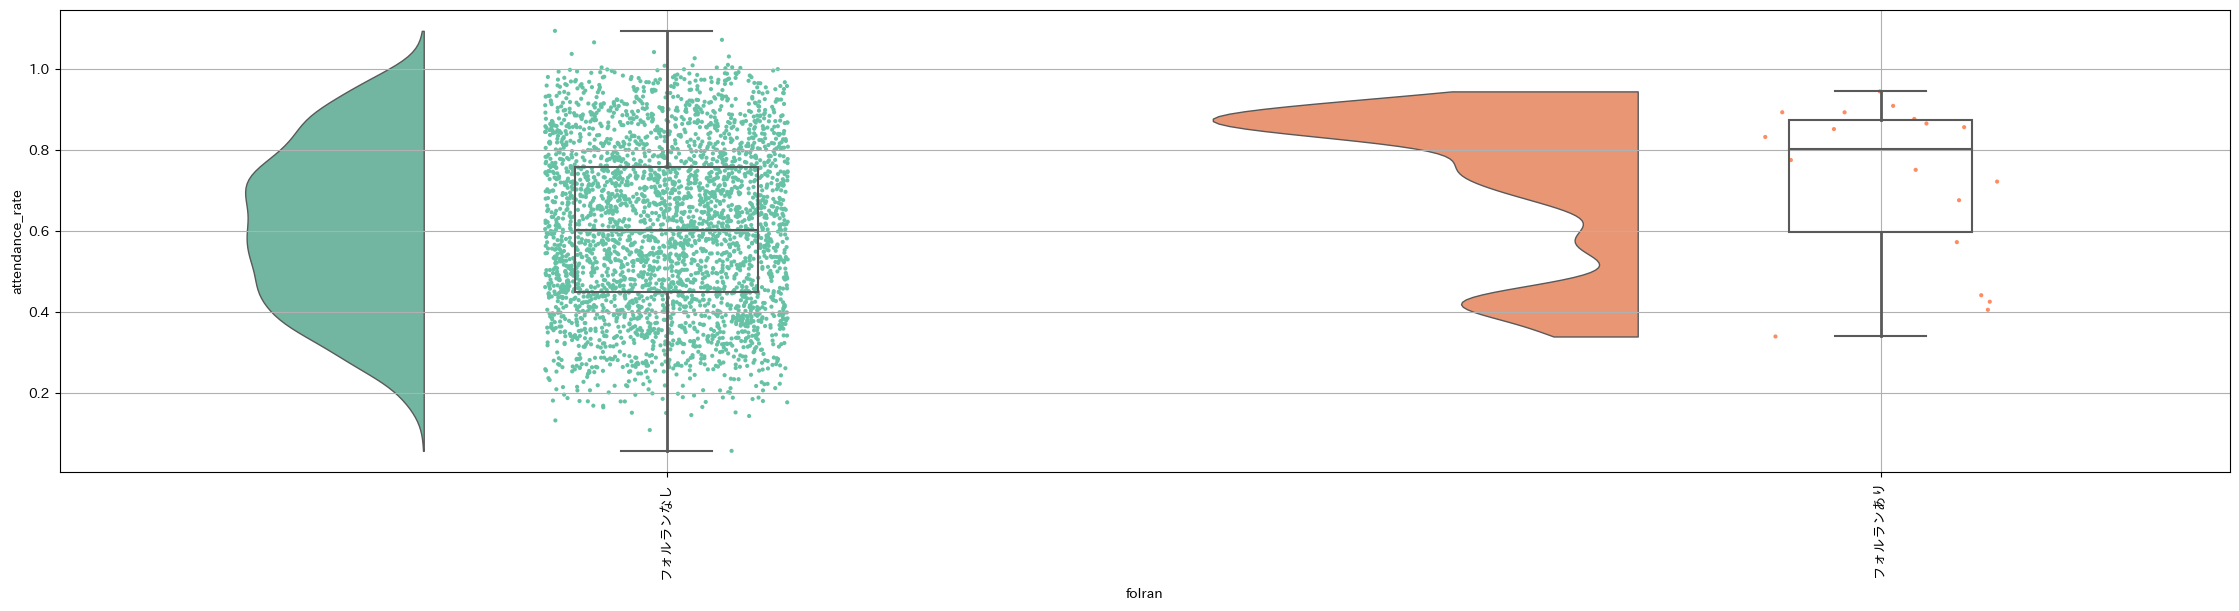

In [74]:
from ptitprince import RainCloud
fig, ax = plt.subplots(figsize=(28, 6))
plt.xticks(rotation=90)
RainCloud(data = df_train, y='attendance_rate', x='folran', ax=ax)
ax.grid()

### ホームチームとアウェイチームが同じ県かどうか

In [75]:
def sameprefecture(df):
    same_prefecture = []
    for i in range(len(df)):
        same_prefecture.append(1)
    df_same_prefecture = pd.DataFrame(same_prefecture, columns=['same_prefecture'])
    df_same_prefecture['same_prefecture'] = '同じ県ではない'
    df = insert_columns(df, df_same_prefecture, after='prefecture')
    
    for i in range(len(df)):
        if df['home_team'][i] == 'G大阪':
            if df['away_team'][i] == 'C大阪':
                df['same_prefecture'][i] = '同じ県'       
        elif df['home_team'][i] == 'C大阪':
            if df['away_team'][i] == 'G大阪':
                df['same_prefecture'][i] = '同じ県'      
        elif df['home_team'][i] == 'FC東京':
            if df['away_team'][i] == '東京V':
                df['same_prefecture'][i] = '同じ県'
        elif df['home_team'][i] == '東京V':
            if df['away_team'][i] == 'FC東京':
                df['same_prefecture'][i] = '同じ県'     
        elif df['home_team'][i] == '磐田':
            if df['away_team'][i] == '清水':
                df['same_prefecture'][i] = '同じ県'      
        elif df['home_team'][i] == '清水':
            if df['away_team'][i] == '磐田':
                df['same_prefecture'][i] = '同じ県'  
        elif df['home_team'][i] == '大宮':
            if df['away_team'][i] == '浦和':
                df['same_prefecture'][i] = '同じ県'  
        elif df['home_team'][i] == '浦和':
            if df['away_team'][i] == '大宮':
                df['same_prefecture'][i] = '同じ県'   
        elif df['home_team'][i] == '柏':
            if df['away_team'][i] == '千葉':
                df['same_prefecture'][i] = '同じ県'   
        elif df['home_team'][i] == '千葉':
            if df['away_team'][i] == '柏':
                df['same_prefecture'][i] = '同じ県'
        elif df['home_team'][i] == '川崎F':
            if df['away_team'][i] in ['横浜FM', '横浜FC', '湘南']:
                df['same_prefecture'][i] = '同じ県'  
        elif df['home_team'][i] == '横浜FM':
            if df['away_team'][i] in ['川崎F', '横浜FC', '湘南']:
                df['same_prefecture'][i] = '同じ県' 
        elif df['home_team'][i] == '横浜FC':
            if df['away_team'][i] in ['川崎F', '横浜FM', '湘南']:
                df['same_prefecture'][i] = '同じ県'  
        elif df['home_team'][i] == '湘南':
            if df['away_team'][i] in ['川崎F', '横浜FC', '横浜FM']:
                df['same_prefecture'][i] = '同じ県'
    
    return df

In [76]:
df_train = sameprefecture(df_train)
df_test = sameprefecture(df_test)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3833589547.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_prefecture'][i] = '同じ県'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3833589547.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_prefecture'][i] = '同じ県'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3833589547.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_prefecture'][i] = '同じ県

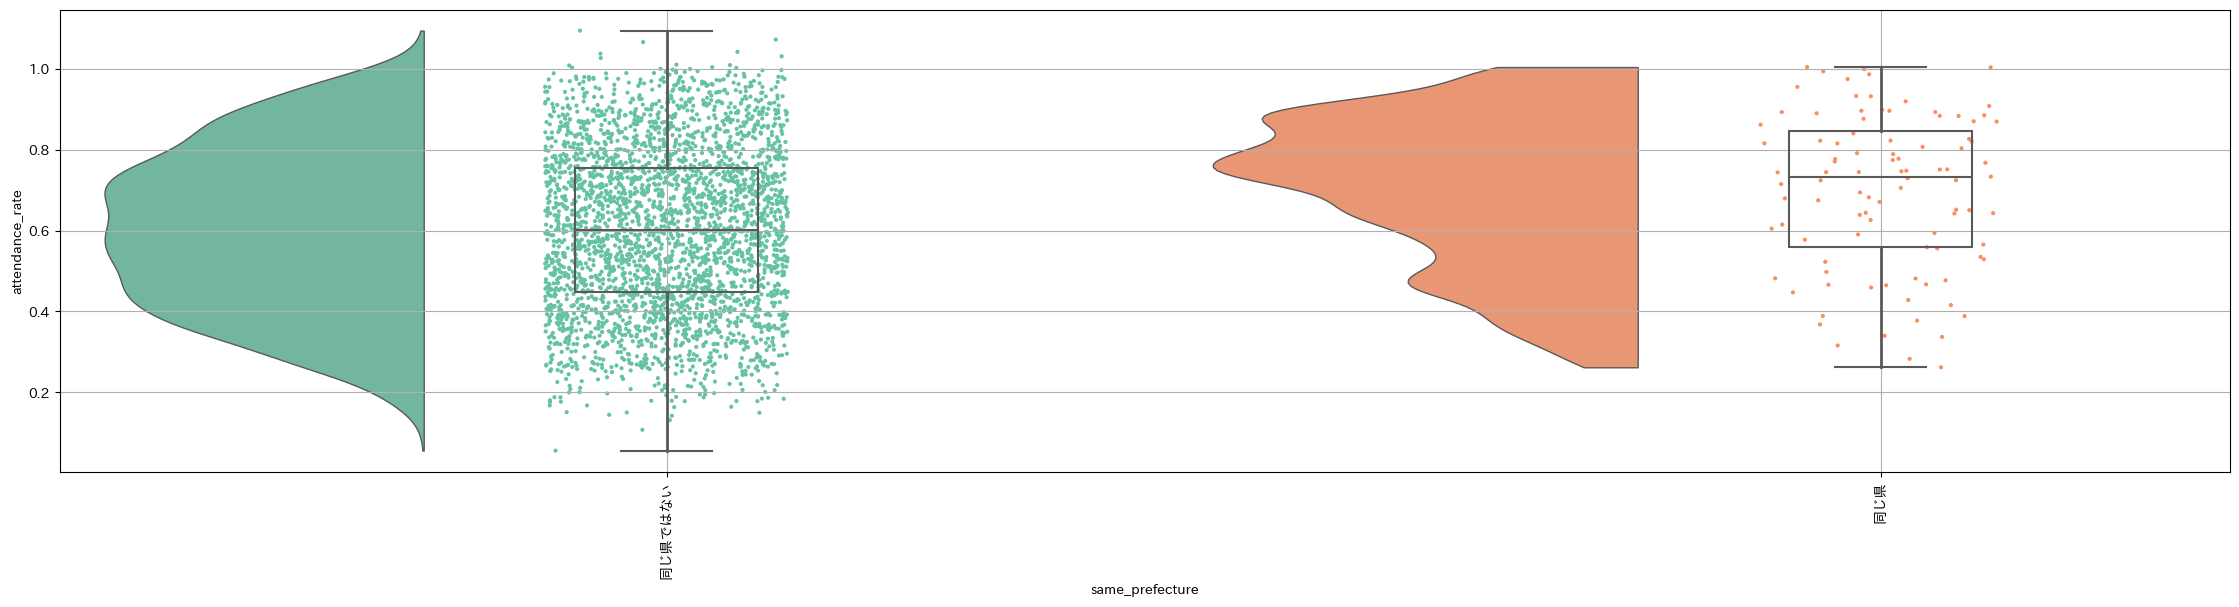

In [77]:
from ptitprince import RainCloud
fig, ax = plt.subplots(figsize=(28, 6))
plt.xticks(rotation=90)
RainCloud(data = df_train, y='attendance_rate', x='same_prefecture', ax=ax)
ax.grid()

### 強豪チーム

In [78]:
strong_team = []

for i in range(len(df_train)):
    if df_train['home_team_before_rank'][i] == '前シーズン1位':
        strong_team.append(df_train['home_team'][i])
    elif df_train['home_team_before_rank'][i] == '前シーズン2位':
        strong_team.append(df_train['home_team'][i])
    elif df_train['home_team_before_rank'][i] == '前シーズン3位':
        strong_team.append(df_train['home_team'][i])
    elif df_train['away_team_before_rank'][i] == '前シーズン1位':
        strong_team.append(df_train['away_team'][i])
    elif df_train['away_team_before_rank'][i] == '前シーズン2位':
        strong_team.append(df_train['away_team'][i])
    elif df_train['away_team_before_rank'][i] == '前シーズン3位':
        strong_team.append(df_train['away_team'][i])

strong_team1 = list(dict.fromkeys(strong_team))

#一回のみは削除
strong_team1.remove('柏')
strong_team1.remove('仙台')
strong_team1.remove('横浜FM')

strong_team1

['川崎F', '浦和', 'G大阪', '鹿島', '名古屋', '広島']

In [79]:
strong_team = []
for i in range(len(df_train)):
    strong_team.append(1)
df_strong_team = pd.DataFrame(strong_team, columns=['strong_team'])
df_strong_team['strong_team'] = '普通'
df_train = insert_columns(df_train, df_strong_team, after='home_team')

strong_awayteam = []
for i in range(len(df_train)):
    strong_awayteam.append(1)
df_strong_awayteam = pd.DataFrame(strong_awayteam, columns=['strong_awayteam'])
df_strong_awayteam['strong_awayteam'] = '普通'
df_train = insert_columns(df_train, df_strong_awayteam, after='away_team')

for i in range(len(df_train)): 
    if df_train['home_team'][i] in strong_team1:
        df_train['strong_team'][i] = '強豪'
    elif df_train['away_team'][i] in strong_team1:
        df_train['strong_awayteam'][i] = '強豪'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3986962288.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['strong_team'][i] = '強豪'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\3986962288.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['strong_awayteam'][i] = '強豪'


In [80]:
strong_team = []
for i in range(len(df_test)):
    strong_team.append(1)
df_strong_team = pd.DataFrame(strong_team, columns=['strong_team'])
df_strong_team['strong_team'] = '普通'
df_test = insert_columns(df_test, df_strong_team, after='home_team')

strong_awayteam = []
for i in range(len(df_test)):
    strong_awayteam.append(1)
df_strong_awayteam = pd.DataFrame(strong_awayteam, columns=['strong_awayteam'])
df_strong_awayteam['strong_awayteam'] = '普通'
df_test = insert_columns(df_test, df_strong_awayteam, after='away_team')

for i in range(len(df_test)): 
    if df_test['home_team'][i] in strong_team1:
        df_test['strong_team'][i] = '強豪'
    elif df_test['away_team'][i] in strong_team1:
        df_test['strong_awayteam'][i] = '強豪'

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1798065850.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['strong_awayteam'][i] = '強豪'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\1798065850.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['strong_team'][i] = '強豪'


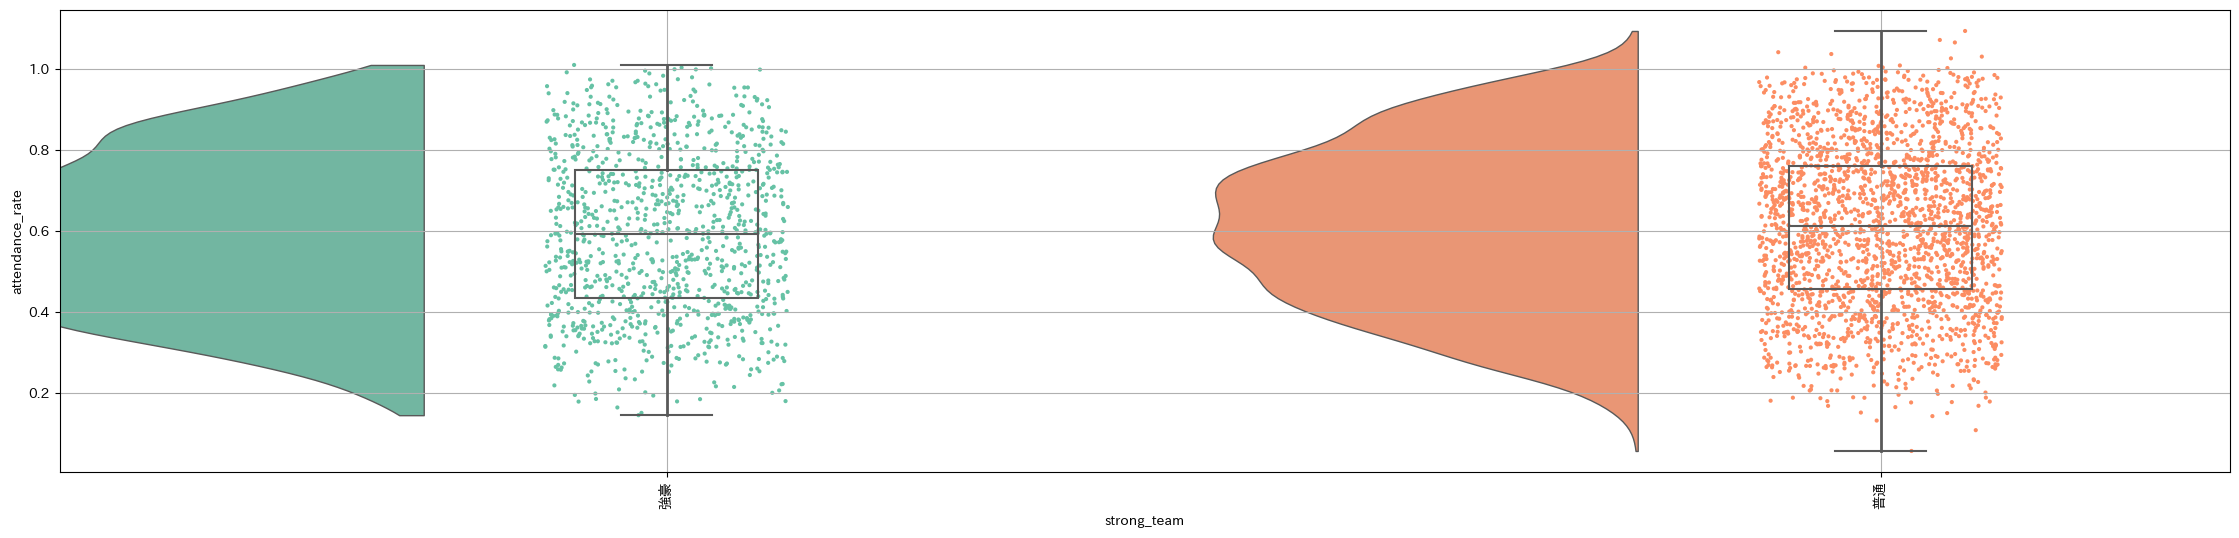

In [81]:
from ptitprince import RainCloud
fig, ax = plt.subplots(figsize=(28, 6))
plt.xticks(rotation=90)
RainCloud(data = df_train, y='attendance_rate', x='strong_team', ax=ax)
ax.grid()

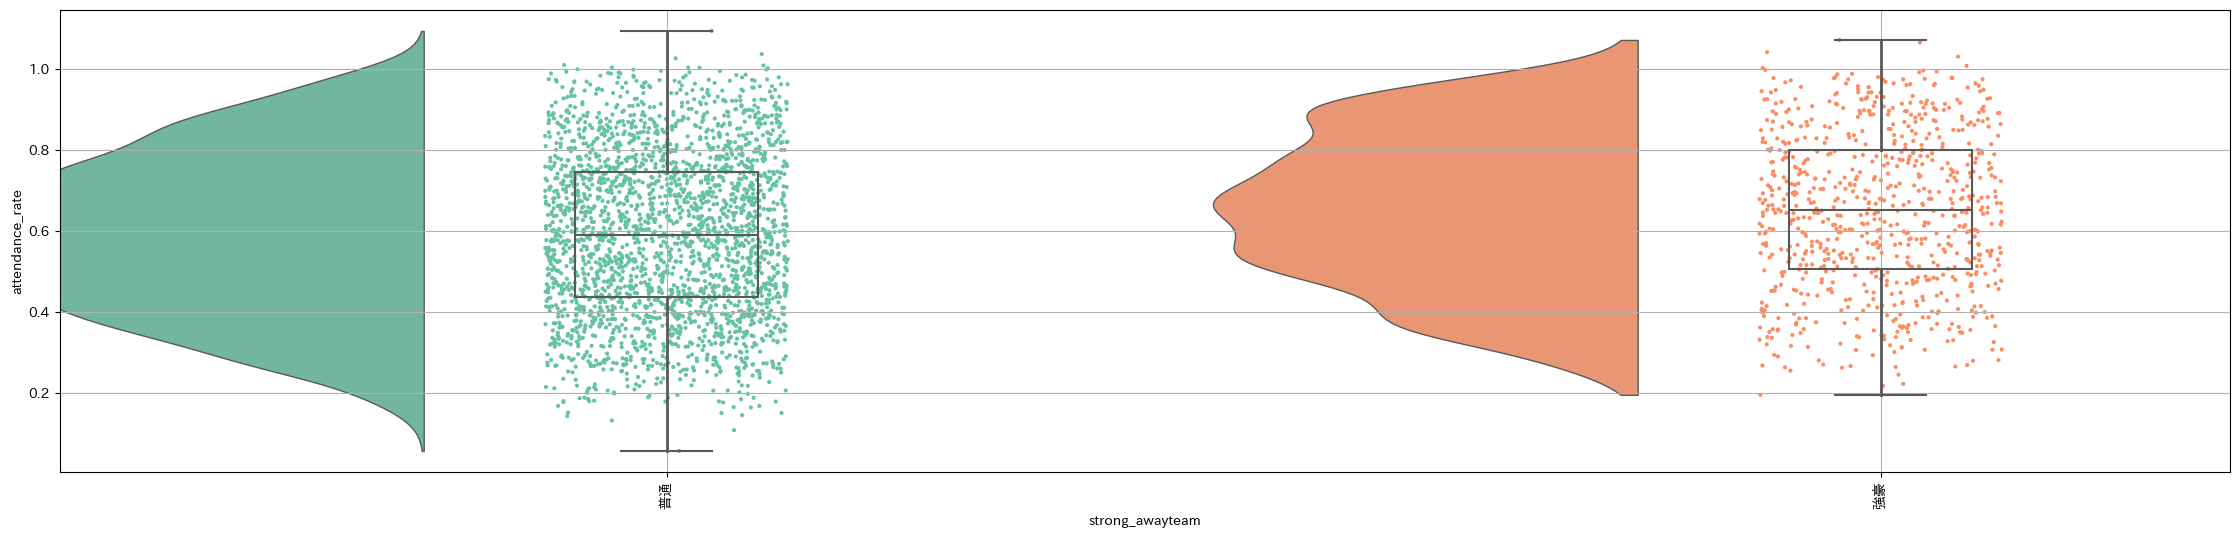

In [82]:
fig, ax = plt.subplots(figsize=(28, 6))
plt.xticks(rotation=90)
RainCloud(data = df_train, y='attendance_rate', x='strong_awayteam', ax=ax)
ax.grid()

### 地方別

In [83]:
area = []
for i in range(len(df_train)):
    area.append(1)
df_area = pd.DataFrame(area, columns=['area'])
df_area['area'] = '関東'
df_train = insert_columns(df_train, df_area, after='address')
df_test = insert_columns(df_test, df_area, after='address')

In [84]:
def area(df_train):
    for i in range(len(df_train)):
        if df_train['prefecture'][i] == '北海道':
            df_train['area'][i] = '北海道'
        elif df_train['prefecture'][i] in ['山形県', '宮城県']:
            df_train['area'][i] = '東北'
        elif df_train['prefecture'][i] in ['新潟県', '石川県']:
            df_train['area'][i] = '北陸'
        elif df_train['prefecture'][i] in ['静岡県', '愛知県', '長野県', '山梨県']:
            df_train['area'][i] = '中部'
        elif df_train['prefecture'][i] in ['大阪府', '京都府', '兵庫県']:
            df_train['area'][i] = '近畿'
        elif df_train['prefecture'][i] == '広島県':
            df_train['area'][i] = '中国'
        elif df_train['prefecture'][i] == '徳島県':
            df_train['area'][i] = '四国'
        elif df_train['prefecture'][i] in ['福岡県', '大分県', '鹿児島県', '佐賀県', '熊本県', '長崎県']:
            df_train['area'][i] = '九州'
    
    return df_train

In [85]:
df_train = area(df_train)
df_test = area(df_test)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2030359253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['area'][i] = '近畿'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2030359253.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['area'][i] = '中部'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\2030359253.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['area'][i] = '中国'
C:\Users\takay\A

### 直近3戦の勝敗

In [195]:
def match_result3(df_train):
    hometeam_match_result = []
    for i in range(len(df_train)):
        hometeam_match_result.append(1)

    df_hometeam_match_result = pd.DataFrame(hometeam_match_result, columns=['hometeam_match_result1'])
    
    df_train = insert_columns(df_train, df_hometeam_match_result, after='hometeam_match_result')

    awayteam_match_result = []
    for i in range(len(df_train)):
        awayteam_match_result.append(1)

    df_awayteam_match_result = pd.DataFrame(awayteam_match_result, columns=['awayteam_match_result1'])
    
    df_train = insert_columns(df_train, df_awayteam_match_result, after='awayteam_match_result')

    for i in range(len(df_train)):
        if df_train['section'][i] == '第1節':
            df_train['hometeam_match_result1'][i] = '一戦目'
            df_train['awayteam_match_result1'][i] = '一戦目'
        elif df_train['section'][i] == '第2節':
            idx = df_train[(df_train['year'] == df_train['year'][i]) & (df_train['section'] == '第' + str(int(df_train['section'][i][1:-1])) + '節')].iloc[0:]
            idx = idx.reset_index(drop=True)
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['home_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        df_train['hometeam_match_result1'][i] = '100%'
                    else:
                        df_train['hometeam_match_result1'][i] = '0%'
                elif df_train['home_team'][i] == idx['away_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        df_train['hometeam_match_result1'][i] = '100%'
                    else:
                        df_train['hometeam_match_result1'][i] = '0%'
                elif df_train['away_team'][i] == idx['home_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        df_train['awayteam_match_result1'][i] = '100%'
                    else:
                        df_train['awayteam_match_result1'][i] = '0%'
                elif df_train['away_team'][i] == idx['away_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        df_train['awayteam_match_result1'][i] = '100%'
                    else:
                        df_train['awayteam_match_result1'][i] = '0%'
        elif df_train['section'][i] == '第3節':
            idx = df_train[(df_train['year'] == df_train['year'][i]) & (df_train['section'].isin(['第2節', '第3節']))]
            idx = idx.reset_index(drop=True)
            n = 0
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['home_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        n += 1
                elif df_train['home_team'][i] == idx['away_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        n += 1
            win = n/2
            df_train['hometeam_match_result1'][i] = str(win) + '%'
            m = 0
            for j in range(len(idx)):
                if df_train['away_team'][i] == idx['home_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        m += 1
                elif df_train['away_team'][i] == idx['away_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        m += 1
            win = n/2
            df_train['awayteam_match_result1'][i] = str(win) + '%'
        else:
            idx = df_train[(df_train['year'] == df_train['year'][i]) & (df_train['section'].isin(['第' + str(int(df_train['section'][i][1:-1])) + '節', '第' + str(int(df_train['section'][i][1:-1]) - 1) + '節', '第' + str(int(df_train['section'][i][1:-1]) - 2) + '節']))]
            idx = idx.reset_index(drop=True)
            n = 0
            for j in range(len(idx)):
                if df_train['home_team'][i] == idx['home_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        n += 1
                elif df_train['home_team'][i] == idx['away_team'][j]:
                    if idx['hometeam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        n += 1
            win = n/3
            df_train['hometeam_match_result1'][i] = str(win) + '%'
            m = 0
            for j in range(len(idx)):
                if df_train['away_team'][i] == idx['home_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち']:
                        m += 1
                elif df_train['away_team'][i] == idx['away_team'][j]:
                    if idx['awayteam_match_result'][j] in ['勝ち', 'ホーム勝ち'] :
                        m += 1
            win = n/3
            df_train['awayteam_match_result1'][i] = str(win) + '%'
    return df_train

In [196]:
df_train = match_result3(df_train)
df_test = match_result3(df_test)

C:\Users\takay\AppData\Local\Temp\ipykernel_17168\4046370545.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['hometeam_match_result1'][i] = '一戦目'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\4046370545.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['awayteam_match_result1'][i] = '一戦目'
C:\Users\takay\AppData\Local\Temp\ipykernel_17168\4046370545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trai

# データ整理

In [197]:
df_train.columns

Index(['id', 'match_date', 'year', 'month', 'day', 'day_of_week', 'rest',
       'long_rest', 'kick_off_time', 'section', 'round', 'home_team',
       'strong_team', 'hometeam_match_result', 'hometeam_match_result1',
       'home_team_player11', 'home_team_player10', 'home_team_player9',
       'home_team_player8', 'home_team_player7', 'home_team_player6',
       'home_team_player5', 'home_team_player4', 'home_team_player3',
       'home_team_player2', 'home_team_player1', 'home_team_before_rank',
       'home_team_after_rank', 'match_result', 'away_team_after_rank',
       'away_team_before_rank', 'away_team_player1', 'away_team_player2',
       'away_team_player3', 'away_team_player4', 'away_team_player5',
       'away_team_player6', 'away_team_player7', 'away_team_player8',
       'away_team_player9', 'away_team_player10', 'away_team_player11',
       'away_team', 'strong_awayteam', 'awayteam_match_result',
       'awayteam_match_result1', 'folran', 'venue', 'home_venue', 'capacity'

In [198]:
df_tr = df_train.drop(['id', 'match_date', 'day', 'round', 'strong_team', 'strong_awayteam', 'folran', 'area', 'match_result', 'municipalities', 'broadcasters'], axis=1)

In [199]:
df_capacity = df_test['cap']
df_test_id = df_test['id']

In [200]:
test = df_test.drop(['id', 'match_date', 'day', 'round', 'strong_team', 'strong_awayteam', 'folran', 'area', 'match_result', 'municipalities', 'broadcasters', 'cap'], axis=1)

# 分析

### 分析に使うデータを作る

In [201]:
y1 = df_tr['attendance_rate']
y2 = df_tr['attendance']
z = df_tr['cap']
df_tr = df_tr.drop(['attendance_rate'], axis=1)
df_tr = df_tr.drop(['attendance'], axis=1)
df_tr = df_tr.drop(['cap'], axis=1)

In [202]:
def data(df):
    for i, col in enumerate(df.columns):
        df[col] = df[col].astype(str)
        if col == 'year':
            pass
        else:
            df['year'] = df['year'].str.cat(df[col], sep=' ')
    df = pd.DataFrame(data={'data' : df['year']})
    return df

In [203]:
df_tr = data(df_tr)
test = data(test)

In [204]:
df_tr = df_tr.join(y1)
df_tr = df_tr.join(y2)
df_tr = df_tr.join(z)

In [205]:
df_tr

,data,attendance_rate,attendance,cap
0,2006年 3月 土曜日 rest_Yes 普通の日 夕方 第1節 G大阪 開幕戦 一戦目 ...,0.996000,20916,21000
1,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 甲府 開幕戦 一戦目 長谷川...,0.900246,14277,15859
2,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 FC東京 開幕戦 一戦目 ル...,0.459826,22531,48999
3,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 磐田 開幕戦 一戦目 西野泰...,0.552527,28564,51697
4,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 名古屋 開幕戦 一戦目 杉本...,0.850467,17199,20223
...,...,...,...,...
3360,2016年 11月 祝日 rest_No 普通の日 昼 第34節 川崎F 勝ち 0.3333...,0.957766,25694,26827
3361,2016年 11月 祝日 rest_No 普通の日 昼 第34節 甲府 負け 0.0% ダヴ...,0.925405,14676,15859
3362,2016年 11月 祝日 rest_No 普通の日 昼 第34節 新潟 負け 0.33333...,0.649674,27081,41684
3363,2016年 11月 祝日 rest_No 普通の日 昼 第34節 名古屋 負け 0.3333...,0.913514,18474,20223


In [206]:
test

,data
0,2017年 2月 土曜日 普通の日 昼 第1節 横浜FM 開幕戦 一戦目 富樫敬真 齋藤学 ...
1,2017年 2月 土曜日 普通の日 昼 第1節 仙台 開幕戦 一戦目 石原直樹 奥埜博亮 永...
2,2017年 2月 土曜日 普通の日 昼 第1節 鹿島 開幕戦 一戦目 ペドロジュニオール 金...
3,2017年 2月 土曜日 普通の日 昼 第1節 清水 開幕戦 一戦目 鄭大世 金子翔太 白崎...
4,2017年 2月 土曜日 普通の日 昼 第1節 広島 開幕戦 一戦目 工藤壮人 フェリペシウ...
...,...
454,2018年 7月 日曜日 長期休み 夜 第17節 FC東京 勝ち 0.66666666666...
455,2018年 7月 日曜日 長期休み 夜 第17節 川崎F 勝ち 0.666666666666...
456,2018年 7月 日曜日 長期休み 夜 第17節 G大阪 負け 0.0% アデミウソン ファ...
457,2018年 7月 日曜日 長期休み 夜 第17節 C大阪 負け 0.333333333333...


# 学習

In [207]:
df_tr[['data', 'cap']]

,data,cap
0,2006年 3月 土曜日 rest_Yes 普通の日 夕方 第1節 G大阪 開幕戦 一戦目 ...,21000
1,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 甲府 開幕戦 一戦目 長谷川...,15859
2,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 FC東京 開幕戦 一戦目 ル...,48999
3,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 磐田 開幕戦 一戦目 西野泰...,51697
4,2006年 3月 日曜日 rest_No 普通の日 昼 第1節 名古屋 開幕戦 一戦目 杉本...,20223
...,...,...
3360,2016年 11月 祝日 rest_No 普通の日 昼 第34節 川崎F 勝ち 0.3333...,26827
3361,2016年 11月 祝日 rest_No 普通の日 昼 第34節 甲府 負け 0.0% ダヴ...,15859
3362,2016年 11月 祝日 rest_No 普通の日 昼 第34節 新潟 負け 0.33333...,41684
3363,2016年 11月 祝日 rest_No 普通の日 昼 第34節 名古屋 負け 0.3333...,20223


## TF-IDF

### スタッキング（１層目）

In [208]:
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(df_tr[['data', 'cap']], df_tr[['attendance_rate', 'attendance']], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'clf__num_leaves': [31, 127],
               'clf__reg_alpha': [0.1, 0.5],
               'clf__min_data_in_leaf': [30, 50, 100, 300, 400],
               'clf__lambda_l1': [0, 1, 1.5],
               'clf__lambda_l2': [0, 1]},
              {'vect__ngram_range': [(1, 1)],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__num_leaves': [31, 127],
               'clf__reg_alpha': [0.1, 0.5],
               'clf__min_data_in_leaf': [30, 50, 100, 300, 400],
               'clf__lambda_l1': [0, 1, 1.5],
               'clf__lambda_l2': [0, 1]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', lgb.LGBMRegressor())])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [209]:
gs_lr_tfidf.fit(X_train['data'], y_train['attendance_rate'])

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'clf__lambda_l1': [0, 1, 1.5],
                          'clf__lambda_l2': [0, 1],
                          'clf__min_data_in_leaf': [30, 50, 100, 300, 400],
                          'clf__num_leaves': [31, 127],
                          'clf__reg_alpha': [0.1, 0.5],
                          'vect__ngram_range': [(1, 1)]},
                         {'clf__lambda_l1': [0, 1, 1.5],
                          'clf__lambda_l2': [0, 1],
                          'clf__min_data_in_leaf': [30, 50, 100, 300, 400],
                          'clf__num_leaves': [31, 127],
                          'clf__reg_alpha': [0.1, 0.5],
                          'vect__ngram_range': [(1, 1)], 'vect__norm': [None],
                          'vect__use_idf': [False]}],
             scoring='neg_mean_squared_error', verbose=2)

In [210]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV RMSE: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__lambda_l1': 0, 'clf__lambda_l2': 1, 'clf__min_data_in_leaf': 30, 'clf__num_leaves': 31, 'clf__reg_alpha': 0.1, 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__use_idf': False} 
CV RMSE: -0.013


In [211]:
clf = gs_lr_tfidf.best_estimator_
y_pred = clf.predict(X_test['data'])
X_test = X_test.reset_index(drop=True)
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] * X_test['cap'][i]
print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(y_test['attendance'], y_pred)))

Test RMSE: 3987.759


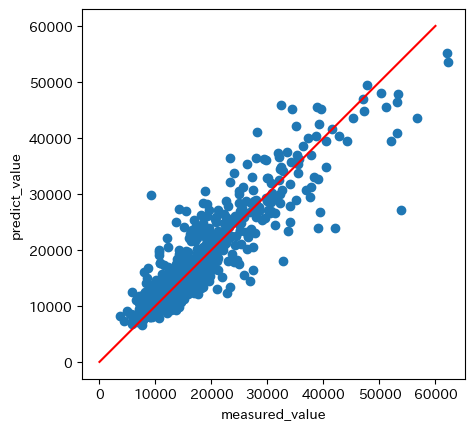

In [212]:
plt.scatter(y_test['attendance'], y_pred)
plt.plot([0,60000], [0,60000], color='red')
plt.xlabel("measured_value")
plt.ylabel("predict_value")
plt.gca().set_aspect('equal', adjustable='box')  
plt.show()

## テストデータ予測

In [213]:
pred = clf.predict(test['data'])

In [214]:
for i in range(len(pred)):
    pred[i] = pred[i] * df_capacity[i]

In [215]:
submit = pd.DataFrame(df_test_id, columns=['id'])
submit['attendance'] = pred
submit = submit.astype('int')

In [216]:
submit

,id,attendance
0,19075,40813
1,19076,16681
2,19077,21799
3,19078,16102
4,19079,18307
...,...,...
454,20893,28376
455,20894,20646
456,20895,23820
457,20896,25829


In [217]:
submit.to_csv('submit_Deloitte.csv', header=False, index=False)

In [218]:
submit[:18]

,id,attendance
0,19075,40813
1,19076,16681
2,19077,21799
3,19078,16102
4,19079,18307
5,19080,14047
6,19081,29685
7,19082,12643
8,19083,27598
9,19084,51754


In [109]:
clf = gs_lr_tfidf.best_estimator_
y_pred = clf.predict(X_test['data'])
X_test = X_test.reset_index(drop=True)
for i in range(len(y_pred)):
    if y_pred[i] > 1:
        y_pred[i] = 1
        y_pred[i] = y_pred[i] * X_test['cap'][i]
    else:
        y_pred[i] = y_pred[i] * X_test['cap'][i]
print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(y_test['attendance'], y_pred)))

Test RMSE: 3945.004
